# Required Libraries

Using `pandas` to read and process tabular data and `missingno` to visualize missing data.

In [1]:
%matplotlib inline

import sys, os

import pandas as pd
import missingno as msn

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt import gp_minimize

/opt/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


# Loading Data Sets

Clinical variables are stored in the file `data/clinical.tsv` while gene variables are stored in `data/gene_count.tsv`.

In [2]:
clinical = pd.read_csv('data/clinical.tsv', sep='\t', index_col='ID')

genecount = pd.read_csv('data/gene_count.tsv', sep='\t', index_col='ID')

clinical_gene = clinical.join(genecount, how='inner')

print('Joined data set contains {} rows and {} columns. See a sample below'.format(clinical_gene.shape[0], clinical_gene.shape[1]))

clinical_gene.iloc[:8, :8]

Joined data set contains 749 rows and 27833 columns. See a sample below


,response_best_response_first_line,response_days_to_disease_progression,cmmc,ecog_ps,cell_markers,percent_aneuploid,percent_plama_cells_bone_marrow,percent_plama_cells_peripherical_blood
ID,,,,,,,,
MMRF1021,0.0,0.0,NaN,PS 1 (Restricted in physically strenuous activ...,CD13,0.0,4.9,0.0
MMRF1024,0.0,1.0,NaN,PS 1 (Restricted in physically strenuous activ...,CD117,11.0,6.0,0.0
MMRF1029,0.0,NaN,NaN,PS 1 (Restricted in physically strenuous activ...,CD117,0.0,8.4,0.0
MMRF1030,1.0,1.0,NaN,PS 1 (Restricted in physically strenuous activ...,CD117,15.4,9.6,0.0
MMRF1031,0.0,1.0,NaN,PS 0 (Fully Active),CD117,18.3,10.1,0.0
MMRF1032,0.0,1.0,NaN,PS 2 (Ambulatory and capable of all selfcare),CD117,20.7,11.1,0.0
MMRF1033,0.0,0.0,NaN,PS 0 (Fully Active),CD117,18.5,12.0,0.0
MMRF1037,0.0,NaN,NaN,PS 1 (Restricted in physically strenuous activ...,CD117,20.7,17.0,0.0


# Filtering Fish Variables

Below in fit models to estimate fish variables from gene counts. We consider X fish variables: 13q14, 13q34, 17p13, 1q21, 11p15, 15q15, 19q13, 20q13, 21q22, 3q21, 5q31, 7q22, 9q33, t_11_14_ccnd1, t_12_14_ccnd2, t_14_16_maf, t_14_20_mafb, t_4_14_whsc1, t_6_14_ccnd3, t_8_14_mafa, t_8_14_myc, and hyperdiploid_flag.

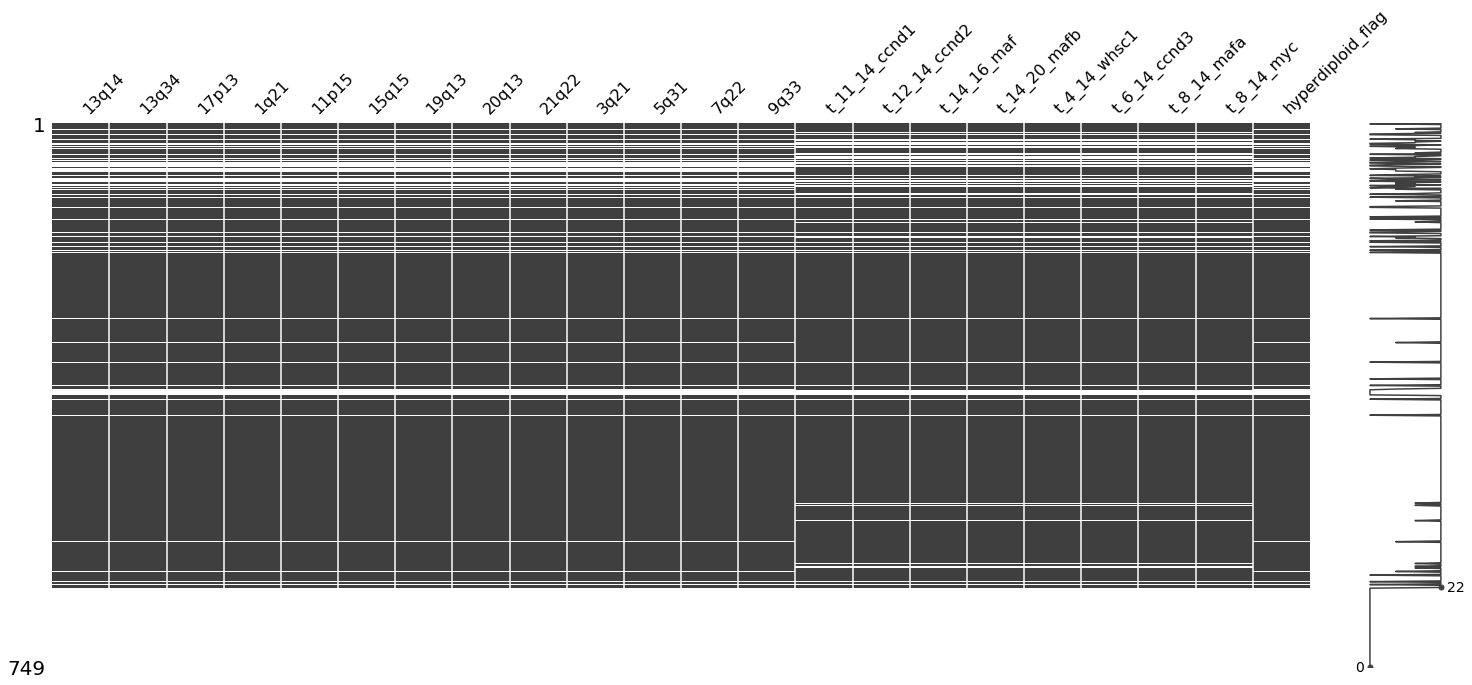

In [3]:
import numpy as np

translocations = [
    '13q14', '13q34', '17p13', '1q21', '11p15', '15q15', '19q13', '20q13', '21q22', '3q21',
    '5q31', '7q22', '9q33', 't_11_14_ccnd1', 't_12_14_ccnd2', 't_14_16_maf', 't_14_20_mafb',
    't_4_14_whsc1',  't_6_14_ccnd3', 't_8_14_mafa', 't_8_14_myc', 'hyperdiploid_flag']

for t in translocations:
    clinical_gene[t] = clinical_gene[t].apply(lambda x: {'Detected': 1, 'Not Detected': 0}.get(x, np.nan))

msn.matrix(clinical_gene[translocations]);

# Hyperparameter Optimization Algorithm

We employ Baysian optimization algoritmo to find best parameters to reduce bias and variances of our models used to complete missing fish variables.

In [4]:
space = [
    Real(1e-6, 9e-1, 'log-uniform', name='learning_rate'),
    Integer(7, 4095, name='num_leaves'),
    Integer(2, 100, name='max_depth'),
    Integer(1, 4000, name='scale_pos_weight'),
    Real(0.01, 1.5, name='min_child_weight'),
    Real(0.4, .9, name='colsample_bytree'),
    Real(0.001, 100, 'log-uniform', name='min_split_gain'),
    Integer(1, 50, name='min_child_samples'),
    Real(0.4, 0.9, name='subsample')]

def optimize(x, y, space, n_calls=50):
    
    @use_named_args(space)
    def objective(num_leaves, max_depth, scale_pos_weight, min_child_weight, colsample_bytree, learning_rate,
                  min_split_gain, min_child_samples, subsample):

        scores = []
        
        kf = StratifiedKFold(2, shuffle=True, random_state=185) 

        params = {
            'learning_rate': learning_rate,
            'num_leaves': int(num_leaves),
            'max_depth': int(max_depth),
            'scale_pos_weight': int(scale_pos_weight),
            'min_child_weight': min_child_weight,
            'colsample_bytree': colsample_bytree,
            'min_split_gain': min_split_gain,
            'min_child_samples': int(min_child_samples),
            'subsample': subsample,
  
            'subsample_for_bin': 2,
            'objective':'binary',
            'metric':'auc',
            'eval_metric':'auc',
            'is_unbalance':False,
            'nthread':24,          
            'verbose': -1}
        
        for train_index, valid_index in kf.split(x, y):
            
            lgb_train = lgb.Dataset(x[train_index,:], y[train_index, 0])
            lgb_valid = lgb.Dataset(x[valid_index,:], y[valid_index, 0])
            
            gbm = lgb.train(params, lgb_train, num_boost_round=1000,  
                            valid_sets=lgb_valid, early_stopping_rounds=100, verbose_eval=False) 

            y_hat = gbm.predict(x[valid_index,:], num_iteration=gbm.best_iteration, verbose_eval=False)

            auc = roc_auc_score(y[valid_index,0], y_hat)
            
            scores.append(auc)
            
        return -(np.mean(scores))
    
    return gp_minimize(objective, space, n_calls=n_calls, random_state=22, verbose=False, n_jobs=-1)

# Fitting Models and Complete Missing Values

In [5]:
from correlation import select_genes
from evaluation import optimize_threshold

import lightgbm as lgb
import pickle
import os

debug = False

fill, aucs = {}, {'var': [], 'auc': []}

clinical_gene_to_fill = clinical_gene[translocations].copy()

for t in translocations:
    
    try:
        
        translocation = clinical_gene[t]

        translocation_fill = translocation[~translocation.isnull()]
        translocation_unfill = translocation[translocation.isnull()]

        train = pd.DataFrame(translocation_fill).join(genecount, how='inner')
        valid = pd.DataFrame(translocation_unfill).join(genecount, how='inner')

        x_train, y_train = train.iloc[:,1:], train.iloc[:,[0]]
        x_valid, y_valid = valid.iloc[:,1:], valid.iloc[:,[0]]

        #
        #
        #
        file_name = 'output/fill/fish_selected_genes_{}.pkl'.format(t)

        if os.path.exists(file_name):
            with open(file_name, 'rb') as file:
                selected_genes = pickle.load(file)

        else:

            selected_genes, pvalues = select_genes(x_train, y_train.values[:,0], threshold=0.05)
            
            #
            # Exporting all selected genes and their p-values
            #
            pd.DataFrame({'gene': selected_genes, 'pvalue': pvalues}).to_csv(
                file_name.replace('pkl', 'csv'), sep=',', index=False)
            
            selected_genes = selected_genes[:min(500, len(selected_genes))]
            
            with open(file_name, 'wb') as file:
                pickle.dump(selected_genes, file)

        if debug:
            print('{} selected genes for translocation {}'.format(len(selected_genes), t))

        x_train, x_valid = x_train[selected_genes], x_valid[selected_genes]

        file_name = 'output/fill/fish_{}.lgbm'.format(t)

        if os.path.exists(file_name):
            gbm = lgb.Booster(model_file=file_name)

        else:
            #
            # Optimization
            #
            if debug:
                print('Optimizing')
            
            opt = optimize(x_train.values, y_train.values, space, n_calls=10).x

            #
            # LightGBM
            #  
            if debug:
                print('Training')

            params = {
                'learning_rate': opt[0],
                'num_leaves': opt[1],
                'max_depth': opt[2],
                'scale_pos_weight': opt[3],
                'min_child_weight': opt[4],
                'colsample_bytree': opt[5],
                'min_split_gain': opt[6],
                'min_child_samples': opt[7],
                'subsample': opt[8],

                'subsample_for_bin': 2,
                'objective':'binary',
                'metric':'auc',
                'eval_metric':'auc',
                'is_unbalance':False,
                'nthread':24,          
                'verbose': -1}

            opt_kf = StratifiedKFold(5, shuffle=True, random_state=185) 

            for opt_train, opt_valid in opt_kf.split(x_train, y_train):

                lgb_train = lgb.Dataset(x_train.values[opt_train,:], list(y_train.values[opt_train,:].reshape((-1,))))
                lgb_valid = lgb.Dataset(x_train.values[opt_valid,:], list(y_train.values[opt_valid,:].reshape((-1,))))

                gbm = lgb.train(params, lgb_train, valid_sets=lgb_valid, num_boost_round=1000, early_stopping_rounds=100, verbose_eval=False)    
                
                auc = roc_auc_score(y_train.values[opt_valid,:], gbm.predict(x_train.values[opt_valid,:]))                
                
                aucs['var'].append(t)
                
                aucs['auc'].append(auc)
                
                if debug:
                    print('AUC: {}'.format(auc))
                
                break
            #
            #
            #
            gbm.save_model(file_name, num_iteration=gbm.best_iteration)

        y_limit = optimize_threshold(y_train, gbm.predict(x_train), 0.0001)

        clinical_gene_to_fill.loc[translocation_unfill.index, t] = [int(v >= y_limit) for v in gbm.predict(x_valid)]
    
    except Exception as e:
        
        exc_type, exc_obj, exc_tb = sys.exc_info()
        
        fname = os.path.split(exc_tb.tb_frame.f_code.co_filename)[1]
        
        if debug:
            print('Some error with translocation {}: {} ({}, {}, {})'.format(t, e, exc_type, fname, exc_tb.tb_lineno))
    
    if debug:
        print('')
    
aucs = pd.DataFrame(aucs)

aucs.to_csv('output/fill/accuracy_fish_aucs.csv', sep=',', index=False)

aucs

,var,auc
0,13q14,0.777709
1,13q34,0.876221
2,17p13,0.874286
3,1q21,0.851351
4,11p15,0.855620
5,15q15,0.918719
6,19q13,0.866256
7,20q13,0.940367
8,21q22,0.788206
9,3q21,0.871272


In [7]:
clinical_gene_to_fill.to_csv('data/filled_fish.csv', sep=',', index=True)

clinical_gene_to_fill.head()

,13q14,13q34,17p13,1q21,11p15,15q15,19q13,20q13,21q22,3q21,...,9q33,t_11_14_ccnd1,t_12_14_ccnd2,t_14_16_maf,t_14_20_mafb,t_4_14_whsc1,t_6_14_ccnd3,t_8_14_mafa,t_8_14_myc,hyperdiploid_flag
ID,,,,,,,,,,,,,,,,,,,,,
MMRF1021,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
MMRF1024,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
MMRF1029,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
MMRF1030,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
MMRF1031,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
